In [1]:
import json
import pandas as pd
from pathlib import Path
from pprint import pprint
import datetime
import time
import numpy as np
import matplotlib as plt

import pandas
import researchpy as rp
import seaborn as sns

import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.stats.multicomp

%matplotlib inline

In [2]:
#path_results = Path('/media/discoD/models/elmo/ner/results_20_epochs_ibm')
#path_results = Path('/media/discoD/models/elmo/ner/results_1_epoch_harem_all_combinations')
path_results = Path('/media/discoD/models/elmo/ner/results')

In [3]:
for folder in path_results.iterdir():
    print(folder)

/media/discoD/models/elmo/ner/results/harem-ft2_ELMo
/media/discoD/models/elmo/ner/results/harem-ft2_ELMo+CNN
/media/discoD/models/elmo/ner/results/harem-ft2_ELMo+CNN+Embeddings
/media/discoD/models/elmo/ner/results/harem-ft2_ELMo+Embeddings


In [4]:
configs = dict()
metrics = dict()
for model_folder in path_results.iterdir():
    if 'Embeddings' in model_folder.name:
        #print('Reading embeddings folder from %s' % model_folder.name)
        for embedding_folder in model_folder.iterdir():
            #print('Reading trainings folder from %s' % embedding_folder.name)
            for training_folder in embedding_folder.iterdir():
                key = embedding_folder.name + '_' + training_folder.name
                #print('Reading files from %s' % key)
                has_metrics = False
                for results_file in training_folder.iterdir():
                    if results_file.name.endswith('.json'):
                        #print('Parsing data from %s' % results_file.name)
                        if results_file.name.startswith('config'):
                            configs[key] = json.loads(results_file.read_bytes())
                        elif results_file.name.startswith('metrics.'):
                            metrics[key] = json.loads(results_file.read_bytes())
                            has_metrics = True
                if not has_metrics:
                    print('metrics.json not found for %s' % key)
                    del configs[key]
    else:
        #print('Reading trainings folder from %s' % model_folder.name)
        for training_folder in model_folder.iterdir():
            key = training_folder.name
            #print('Reading files from %s' % key)
            has_metrics = False
            for results_file in training_folder.iterdir():
                if results_file.name.endswith('.json'):
                    #print('Parsing data from %s' % results_file.name)
                    if results_file.name.startswith('config'):
                        configs[key] = json.loads(results_file.read_bytes())
                    elif results_file.name.startswith('metrics.'):
                        metrics[key] = json.loads(results_file.read_bytes())
                        has_metrics = True
            if not has_metrics:
                print('metrics.json not found for %s' % key)
                del configs[key]
print(len(metrics))
print(len(configs))

metrics.json not found for harem-ft2_ELMo+Embeddings_fasttext_cbow_0_0
metrics.json not found for harem-ft2_ELMo+Embeddings_fasttext_cbow_0_1
metrics.json not found for harem-ft2_ELMo+Embeddings_fasttext_cbow_0_2
metrics.json not found for harem-ft2_ELMo+Embeddings_fasttext_cbow_0_3
metrics.json not found for harem-ft2_ELMo+Embeddings_fasttext_cbow_1_0
metrics.json not found for harem-ft2_ELMo+Embeddings_fasttext_cbow_1_1
metrics.json not found for harem-ft2_ELMo+Embeddings_fasttext_cbow_1_2
metrics.json not found for harem-ft2_ELMo+Embeddings_fasttext_cbow_1_3
metrics.json not found for harem-ft2_ELMo+Embeddings_fasttext_cbow_2_0
metrics.json not found for harem-ft2_ELMo+Embeddings_fasttext_cbow_2_1
metrics.json not found for harem-ft2_ELMo+Embeddings_fasttext_cbow_2_2
metrics.json not found for harem-ft2_ELMo+Embeddings_fasttext_cbow_2_3
metrics.json not found for harem-ft2_ELMo+Embeddings_fasttext_cbow_2_4
metrics.json not found for harem-ft2_ELMo+Embeddings_fasttext_cbow_3_0
metric

metrics.json not found for harem-ft2_ELMo+Embeddings_wang2vec_skip_2_0
metrics.json not found for harem-ft2_ELMo+Embeddings_wang2vec_skip_2_1
metrics.json not found for harem-ft2_ELMo+Embeddings_wang2vec_skip_2_2
metrics.json not found for harem-ft2_ELMo+Embeddings_wang2vec_skip_2_3
metrics.json not found for harem-ft2_ELMo+Embeddings_wang2vec_skip_3_0
metrics.json not found for harem-ft2_ELMo+Embeddings_wang2vec_skip_3_1
metrics.json not found for harem-ft2_ELMo+Embeddings_wang2vec_skip_3_2
metrics.json not found for harem-ft2_ELMo+Embeddings_wang2vec_skip_3_3
metrics.json not found for harem-ft2_ELMo+Embeddings_wang2vec_skip_4_0
metrics.json not found for harem-ft2_ELMo+Embeddings_wang2vec_skip_4_1
metrics.json not found for harem-ft2_ELMo+Embeddings_wang2vec_skip_4_2
metrics.json not found for harem-ft2_ELMo+Embeddings_wang2vec_skip_4_3
metrics.json not found for harem-ft2_ELMo+Embeddings_wang2vec_cbow_5_0
metrics.json not found for harem-ft2_ELMo+Embeddings_wang2vec_cbow_5_1
metric

metrics.json not found for harem-ft2_ELMo+Embeddings_word2vec_cbow_4_3
metrics.json not found for harem-ft2_ELMo+Embeddings_word2vec_skip_0_0
metrics.json not found for harem-ft2_ELMo+Embeddings_word2vec_skip_5_0
414
414


In [5]:
def get_seconds(time_str):
    x = time.strptime(time_str,'%H:%M:%S')
    return datetime.timedelta(hours=x.tm_hour,minutes=x.tm_min,seconds=x.tm_sec).total_seconds()
def get_average_epoch_duration(metrics):
    seconds = get_seconds(metrics['training_duration'])
    training_epochs = metrics['training_epochs'] + 1
    return seconds / training_epochs

In [6]:
TRAINING_ID = 'Training_ID'
SCENARIO = 'Scenario'
MODEL = 'Model'
REPRESENTATION = 'Representation'
EMBEDDING = 'Embedding'
EMBEDDING_TYPE = 'Embedding_Type'
BATCH_SIZE = 'Batch_Size'
ELMO_DROPOUT = 'ELMo_Dropout'
TRAINING_NUMBER = 'Training_Number'
EXECUTION_NUMBER = 'Execution_Number'
BEST_EPOCH = 'Best_Epoch'
TRAINING_EPOCHS = 'Training_Epochs'
TRAINING_DURATION = 'Training_Duration'
TOTAL_DURATION = 'Total_Duration(s)'
AVERAGE_EPOCH_DURATION = 'Average_Epoch_Duration(s)'
TRAINING_ACCURACY = 'Training_Accuracy'
TRAINING_ACCURACY_TOP3 = 'Training_Accuracy_Top-3'
TRAINING_PRECISION = 'Training_Precision'
TRAINING_RECALL = 'Training_Recall'
TRAINING_F1_MEASURE = 'Training_F1-Measure'
TRAINING_LOSS = 'Training_Loss'
BEST_VALIDATION_ACCURACY = 'Best_Validation_Accuracy'
BEST_VALIDATION_ACCURACY_TOP3 = 'Best_Validation_Accuracy_Top-3'
BEST_VALIDATION_PRECISION = 'Best_Validation_Precision'
BEST_VALIDATION_RECALL = 'Best_Validation_Recall'
BEST_VALIDATION_F1_MEASURE = 'Best_Validation_F1-Measure'
BEST_VALIDATION_LOSS = 'Best_Validation_Loss'
TEST_ACCURACY = 'Test_Accuracy'
TEST_ACCURACY_TOP3 = 'Test_Accuracy_Top-3'
TEST_PRECISION = 'Test_Precision'
TEST_RECALL = 'Test_Recall'
TEST_F1_MEASURE = 'Test_F1_Measure'
TEST_LOSS = 'Test_Loss'
columns = [TRAINING_ID, MODEL, REPRESENTATION, EMBEDDING, EMBEDDING_TYPE, TRAINING_NUMBER, EXECUTION_NUMBER, BEST_EPOCH, TRAINING_EPOCHS, TRAINING_DURATION, TOTAL_DURATION, AVERAGE_EPOCH_DURATION, TRAINING_ACCURACY, TRAINING_ACCURACY_TOP3, TRAINING_PRECISION, TRAINING_RECALL, TRAINING_F1_MEASURE, TRAINING_LOSS, BEST_VALIDATION_ACCURACY, BEST_VALIDATION_ACCURACY_TOP3, BEST_VALIDATION_PRECISION, BEST_VALIDATION_RECALL, BEST_VALIDATION_F1_MEASURE, BEST_VALIDATION_LOSS, TEST_ACCURACY, TEST_ACCURACY_TOP3, TEST_PRECISION, TEST_RECALL, TEST_F1_MEASURE, TEST_LOSS]
columns

['Training_ID',
 'Model',
 'Representation',
 'Embedding',
 'Embedding_Type',
 'Training_Number',
 'Execution_Number',
 'Best_Epoch',
 'Training_Epochs',
 'Training_Duration',
 'Total_Duration(s)',
 'Average_Epoch_Duration(s)',
 'Training_Accuracy',
 'Training_Accuracy_Top-3',
 'Training_Precision',
 'Training_Recall',
 'Training_F1-Measure',
 'Training_Loss',
 'Best_Validation_Accuracy',
 'Best_Validation_Accuracy_Top-3',
 'Best_Validation_Precision',
 'Best_Validation_Recall',
 'Best_Validation_F1-Measure',
 'Best_Validation_Loss',
 'Test_Accuracy',
 'Test_Accuracy_Top-3',
 'Test_Precision',
 'Test_Recall',
 'Test_F1_Measure',
 'Test_Loss']

In [7]:
def get_training_data_from_id(training_id, config):
    data = training_id.split('_')
    print(data)
    if len(data) == 4:
        return {MODEL: data[0], REPRESENTATION: data[1], EMBEDDING: 'No', EMBEDDING_TYPE: 'No', TRAINING_NUMBER: data[2], EXECUTION_NUMBER: data[3]}
    elif len(data) == 5:
        #GloVe
        return {MODEL: data[0], REPRESENTATION: data[1], EMBEDDING: data[2], EMBEDDING_TYPE: 'No', TRAINING_NUMBER: data[3], EXECUTION_NUMBER: data[4]}
    elif len(data) == 6:
        embedding_type = data[3] if data[2] != 'glove' else 'No'
        return {MODEL: data[0], REPRESENTATION: data[1], EMBEDDING: data[2], EMBEDDING_TYPE: embedding_type, TRAINING_NUMBER: data[4], EXECUTION_NUMBER: data[5]}
    else:
        print('Check id: %s' % training_id)

In [8]:
training_data = []
for training_id, config in configs.items():
    training_metrics = metrics[training_id]
    data = get_training_data_from_id(training_id, config)
    data[TRAINING_ID] = training_id
    data[BEST_EPOCH] = training_metrics['best_epoch'] if training_metrics else None
    data[TRAINING_EPOCHS] = training_metrics['training_epochs'] + 1 if training_metrics else None
    data[TRAINING_DURATION] = training_metrics['training_duration'] if training_metrics else None
    data[TOTAL_DURATION] = get_seconds(training_metrics['training_duration']) if training_metrics else None
    data[AVERAGE_EPOCH_DURATION] = get_average_epoch_duration(training_metrics) if training_metrics else None
    data[TRAINING_ACCURACY] = training_metrics['training_accuracy'] if training_metrics else None
    data[TRAINING_ACCURACY_TOP3] = training_metrics['training_accuracy3'] if training_metrics else None
    data[TRAINING_PRECISION] = training_metrics['training_precision-overall'] if training_metrics else None
    data[TRAINING_RECALL] = training_metrics['training_recall-overall'] if training_metrics else None
    data[TRAINING_F1_MEASURE] = training_metrics['training_f1-measure-overall'] if training_metrics else None
    data[TRAINING_LOSS] = training_metrics['training_loss'] if training_metrics else None
    data[BEST_VALIDATION_ACCURACY] = training_metrics['best_validation_accuracy'] if training_metrics else None
    data[BEST_VALIDATION_ACCURACY_TOP3] = training_metrics['best_validation_accuracy3'] if training_metrics else None
    data[BEST_VALIDATION_PRECISION] = training_metrics['best_validation_precision-overall'] if training_metrics else None
    data[BEST_VALIDATION_RECALL] = training_metrics['best_validation_recall-overall'] if training_metrics else None
    data[BEST_VALIDATION_F1_MEASURE] = training_metrics['best_validation_f1-measure-overall'] if training_metrics else None
    data[BEST_VALIDATION_LOSS] = training_metrics['best_validation_loss'] if training_metrics else None
    data[TEST_ACCURACY] = training_metrics['test_accuracy'] if training_metrics else None
    data[TEST_ACCURACY_TOP3] = training_metrics['test_accuracy3'] if training_metrics else None
    data[TEST_PRECISION] = training_metrics['test_precision-overall'] if training_metrics else None
    data[TEST_RECALL] = training_metrics['test_recall-overall'] if training_metrics else None
    data[TEST_F1_MEASURE] = training_metrics['test_f1-measure-overall'] if training_metrics else None
    data[TEST_LOSS] = training_metrics['test_loss'] if training_metrics else None
    training_data.append(data)

['harem-ft2', 'ELMo', '4', '1']
['harem-ft2', 'ELMo', '0', '0']
['harem-ft2', 'ELMo', '0', '1']
['harem-ft2', 'ELMo', '0', '2']
['harem-ft2', 'ELMo', '0', '3']
['harem-ft2', 'ELMo', '0', '4']
['harem-ft2', 'ELMo', '1', '0']
['harem-ft2', 'ELMo', '1', '1']
['harem-ft2', 'ELMo', '1', '2']
['harem-ft2', 'ELMo', '1', '3']
['harem-ft2', 'ELMo', '1', '4']
['harem-ft2', 'ELMo', '2', '0']
['harem-ft2', 'ELMo', '2', '1']
['harem-ft2', 'ELMo', '2', '2']
['harem-ft2', 'ELMo', '2', '3']
['harem-ft2', 'ELMo', '3', '0']
['harem-ft2', 'ELMo', '3', '1']
['harem-ft2', 'ELMo', '3', '2']
['harem-ft2', 'ELMo', '3', '3']
['harem-ft2', 'ELMo', '4', '0']
['harem-ft2', 'ELMo', '4', '2']
['harem-ft2', 'ELMo', '4', '3']
['harem-ft2', 'ELMo', '5', '0']
['harem-ft2', 'ELMo', '5', '1']
['harem-ft2', 'ELMo', '5', '2']
['harem-ft2', 'ELMo', '5', '3']
['harem-ft2', 'ELMo', '6', '0']
['harem-ft2', 'ELMo', '6', '1']
['harem-ft2', 'ELMo', '6', '2']
['harem-ft2', 'ELMo', '6', '3']
['harem-ft2', 'ELMo', '7', '0']
['harem-

In [9]:
pd.set_option('display.max_columns', 1000)
training_data_df = pd.DataFrame(training_data, columns=columns)
#training_data_df = training_data_df[(training_data_df[TRAINING_NUMBER]).astype(int) < 9]
training_data_df 

,Training_ID,Model,Representation,Embedding,Embedding_Type,Training_Number,Execution_Number,Best_Epoch,Training_Epochs,Training_Duration,Total_Duration(s),Average_Epoch_Duration(s),Training_Accuracy,Training_Accuracy_Top-3,Training_Precision,Training_Recall,Training_F1-Measure,Training_Loss,Best_Validation_Accuracy,Best_Validation_Accuracy_Top-3,Best_Validation_Precision,Best_Validation_Recall,Best_Validation_F1-Measure,Best_Validation_Loss,Test_Accuracy,Test_Accuracy_Top-3,Test_Precision,Test_Recall,Test_F1_Measure,Test_Loss
0,harem-ft2_ELMo_4_1,harem-ft2,ELMo,No,No,4,1,4,5,00:04:48,288.0,57.6,0.987486,0.988595,0.873585,0.859354,0.866411,26.902914,0.983952,0.985339,0.846341,0.832134,0.839178,36.204509,0.977756,0.979587,0.807949,0.807679,0.807814,53.781262
1,harem-ft2_ELMo_0_0,harem-ft2,ELMo,No,No,0,0,3,5,00:04:58,298.0,59.6,0.987674,0.988760,0.869790,0.861111,0.865429,26.584419,0.978582,0.980876,0.800000,0.806122,0.803050,51.939048,0.977576,0.979377,0.813548,0.793990,0.803650,55.627695
2,harem-ft2_ELMo_0_1,harem-ft2,ELMo,No,No,0,1,3,5,00:04:50,290.0,58.0,0.987797,0.988861,0.874315,0.861111,0.867663,26.680440,0.978800,0.981314,0.810256,0.806122,0.808184,51.726150,0.976931,0.978882,0.813495,0.784975,0.798980,57.563143
3,harem-ft2_ELMo_0_2,harem-ft2,ELMo,No,No,0,2,3,5,00:04:49,289.0,57.8,0.987786,0.988827,0.874521,0.860841,0.867627,27.220980,0.977380,0.980002,0.794937,0.801020,0.797967,52.209078,0.977456,0.979377,0.824513,0.790651,0.807227,58.546175
4,harem-ft2_ELMo_0_3,harem-ft2,ELMo,No,No,0,3,3,5,00:04:44,284.0,56.8,0.987596,0.988682,0.872907,0.857605,0.865188,27.336812,0.979019,0.981532,0.805627,0.803571,0.804598,51.912799,0.976675,0.978612,0.815972,0.784641,0.800000,58.477434
5,harem-ft2_ELMo_0_4,harem-ft2,ELMo,No,No,0,4,3,5,00:04:47,287.0,57.4,0.987596,0.988659,0.870386,0.858414,0.864358,27.039374,0.978472,0.980767,0.803030,0.811224,0.807107,51.332673,0.976765,0.978672,0.816164,0.785643,0.800612,58.266480
6,harem-ft2_ELMo_1_0,harem-ft2,ELMo,No,No,1,0,4,5,00:04:50,290.0,58.0,0.986860,0.988014,0.866010,0.852031,0.858964,28.053235,0.986059,0.987353,0.850900,0.864230,0.857513,32.460055,0.978011,0.979782,0.819167,0.807679,0.813383,53.935775
7,harem-ft2_ELMo_1_1,harem-ft2,ELMo,No,No,1,1,4,5,00:04:46,286.0,57.2,0.986679,0.987799,0.868933,0.852569,0.860674,28.300593,0.984366,0.985760,0.835443,0.861619,0.848329,33.537713,0.977726,0.979437,0.814765,0.810684,0.812720,52.725777
8,harem-ft2_ELMo_1_2,harem-ft2,ELMo,No,No,1,2,3,5,00:04:50,290.0,58.0,0.986611,0.987753,0.865606,0.849072,0.857259,28.216923,0.986158,0.987353,0.857895,0.851175,0.854522,33.737745,0.977201,0.978957,0.817488,0.786644,0.801770,54.705678
9,harem-ft2_ELMo_1_3,harem-ft2,ELMo,No,No,1,3,3,5,00:04:48,288.0,57.6,0.987120,0.988262,0.867744,0.852569,0.860090,27.956835,0.985859,0.987054,0.853786,0.853786,0.853786,34.103467,0.977186,0.978972,0.818024,0.787980,0.802721,53.839189


In [10]:
training_data_df[training_data_df.Embedding_Type == 'glove']

,Training_ID,Model,Representation,Embedding,Embedding_Type,Training_Number,Execution_Number,Best_Epoch,Training_Epochs,Training_Duration,Total_Duration(s),Average_Epoch_Duration(s),Training_Accuracy,Training_Accuracy_Top-3,Training_Precision,Training_Recall,Training_F1-Measure,Training_Loss,Best_Validation_Accuracy,Best_Validation_Accuracy_Top-3,Best_Validation_Precision,Best_Validation_Recall,Best_Validation_F1-Measure,Best_Validation_Loss,Test_Accuracy,Test_Accuracy_Top-3,Test_Precision,Test_Recall,Test_F1_Measure,Test_Loss


In [11]:
#training_data_df.to_csv('training_data_5_epochs_mestrado_all_reps.csv', index=None)

In [12]:
str(datetime.timedelta(seconds=training_data_df[TOTAL_DURATION].mean()))

'0:05:13.775362'

In [13]:
default_exported_columns = ['mean', 'min', 'max', 'std']
renamed_columns = ['Contagem', 'F-Score', 'Desvio Padrão', 'Mínimo', '25%', '50%', '75%', 'Máximo']
exported_columns_names = ['F-Score', 'Mínimo', 'Máximo', 'Desvio Padrão']
model_map = {'harem-ft': 'Sim', 'harem': 'Não'}
representation_map = {'ELMo+CNN+Embeddings': 'ELMo+CNN+Vetor', 'ELMo+Embeddings': 'ELMo+Vetor'}
embedding_type_map = {'skip': 'Skip-Gram', 'No': 'Sem Vetor', 'cbow': 'CBoW'}
embedding_map = {'wang2vec': 'Wang2Vec', 'glove': 'GloVe', 'word2vec': 'Word2Vec', 'No': 'Sem Vetor', 'fasttext': 'FastText'}
replacements_map = {**model_map, **representation_map, **embedding_type_map, **embedding_map}

def get_group_csv(index_names, group_name, group_columns, target_value, index_map, dataframe=training_data_df, exported_columns=default_exported_columns):
    if type(index_names) == str:
        index_names = [index_names]
    group = dataframe.groupby(group_columns).describe()[target_value].sort_values(by='mean', ascending=False)
    for column in exported_columns:
        group[column] = group[column] * 100
    group.index.names = index_names
    group = group.rename(index=index_map)
    group.columns = renamed_columns
    #group.to_csv('grupo_' + group_name + '_5_epochs_mestrado_all_reps.csv', columns=exported_columns_names, float_format = '%.2f%%')
    return group

In [14]:
get_group_csv('Ajuste Fino', MODEL, MODEL, TEST_F1_MEASURE, model_map)

,Contagem,F-Score,Desvio Padrão,Mínimo,25%,50%,75%,Máximo
Ajuste Fino,,,,,,,,
harem-ft2,414.0,80.476751,0.867353,77.256441,0.799731,0.80628,0.811247,82.150683


In [15]:
get_group_csv('Representação', REPRESENTATION, REPRESENTATION, TEST_F1_MEASURE, representation_map)

,Contagem,F-Score,Desvio Padrão,Mínimo,25%,50%,75%,Máximo
Representação,,,,,,,,
ELMo+CNN,43.0,80.561971,0.555640,79.523892,0.801988,0.804923,0.809692,81.664099
ELMo,42.0,80.520040,0.984898,77.256441,0.802007,0.807019,0.811776,81.790541
ELMo+CNN+Vetor,301.0,80.496035,0.889016,77.699055,0.799662,0.806591,0.811639,82.150683
ELMo+Vetor,28.0,80.073636,0.765096,77.928154,0.797195,0.799491,0.805989,81.423463


In [16]:
get_group_csv('Tipo de Vetor', EMBEDDING_TYPE, EMBEDDING_TYPE, TEST_F1_MEASURE, embedding_type_map)

,Contagem,F-Score,Desvio Padrão,Mínimo,25%,50%,75%,Máximo
Tipo de Vetor,,,,,,,,
Skip-Gram,141.0,80.648872,0.731679,77.975193,0.802776,0.808020,0.811773,82.039986
Sem Vetor,132.0,80.544911,0.819268,77.256441,0.801707,0.806506,0.811251,81.790541
CBoW,141.0,80.240819,0.982652,77.699055,0.795341,0.802550,0.810218,82.150683


In [17]:
get_group_csv('Vetor', EMBEDDING, EMBEDDING, TEST_F1_MEASURE, embedding_map)

,Contagem,F-Score,Desvio Padrão,Mínimo,25%,50%,75%,Máximo
Vetor,,,,,,,,
Word2Vec,94.0,80.765919,0.764740,78.036437,0.803277,0.809459,0.812369,82.150683
Wang2Vec,94.0,80.592599,0.820445,77.975193,0.801308,0.807568,0.812053,82.039986
GloVe,47.0,80.551528,0.874132,77.928154,0.800710,0.807576,0.811532,81.781377
Sem Vetor,85.0,80.541252,0.792639,77.256441,0.801770,0.806293,0.811212,81.790541
FastText,94.0,79.976019,0.882809,77.699055,0.793231,0.799730,0.807480,81.600832


In [18]:
get_group_csv(['Ajuste Fino', 'Representação', 'Vetor', 'Tipo de Vetor'], 'Model_Rep_Emb_Emb-Typ', [MODEL, REPRESENTATION, EMBEDDING, EMBEDDING_TYPE], TEST_F1_MEASURE, replacements_map)

Contagem    F-Score  \
Ajuste Fino Representação  Vetor     Tipo de Vetor                        
harem-ft2   ELMo+CNN+Vetor Word2Vec  CBoW               43.0  80.822488   
                                     Skip-Gram          43.0  80.764712   
            ELMo+Vetor     Word2Vec  Skip-Gram           4.0  80.724345   
            ELMo+CNN+Vetor GloVe     Sem Vetor          43.0  80.667236   
                           Wang2Vec  CBoW               43.0  80.639091   
                           FastText  Skip-Gram          43.0  80.624932   
                           Wang2Vec  Skip-Gram          43.0  80.617416   
            ELMo+CNN       Sem Vetor Sem Vetor          43.0  80.561971   
            ELMo           Sem Vetor Sem Vetor          42.0  80.520040   
            ELMo+Vetor     FastText  Skip-Gram           4.0  80.416526   
                           Wang2Vec  CBoW                4.0  80.262646   
                           Word2Vec  CBoW                4.0  80.212349   
                           Wang2Vec  Skip-Gram           4.0  80.155982   
                           FastText  CBoW                4.0  79.435938   
            ELMo+CNN+Vetor FastText  CBoW               43.0  79.336369   
            ELMo+Vetor     GloVe     Sem Vetor           4.0  79.307669   

                                                    Desvio Padrão     Mínimo  \
Ajuste Fino Representação  Vetor     Tipo de Vetor                             
harem-ft2   ELMo+CNN+Vetor Word2Vec  CBoW                0.748475  79.222074   
                                     Skip-Gram           0.798868  78.036437   
            ELMo+Vetor     Word2Vec  Skip-Gram           0.734827  79.898820   
            ELMo+CNN+Vetor GloVe     Sem Vetor           0.776253  78.989048   
                           Wang2Vec  CBoW                0.850267  78.380648   
                           FastText  Skip-Gram           0.596331  79.197393   
                           Wang2Vec  Skip-Gram           0.822624  77.975193   
            ELMo+CNN       Sem Vetor Sem Vetor           0.555640  79.523892   
            ELMo           Sem Vetor Sem Vetor           0.984898  77.256441   
            ELMo+Vetor     FastText  Skip-Gram           0.543799  79.648411   
                           Wang2Vec  CBoW                0.830949  79.273828   
                           Word2Vec  CBoW                0.595983  79.744065   
                           Wang2Vec  Skip-Gram           0.376945  79.743200   
                           FastText  CBoW                0.302025  79.195306   
            ELMo+CNN+Vetor FastText  CBoW                0.667973  77.699055   
            ELMo+Vetor     GloVe     Sem Vetor           1.012687  77.928154   

                                                         25%       50%  \
Ajuste Fino Representação  Vetor     Tipo de Vetor                       
harem-ft2   ELMo+CNN+Vetor Word2Vec  CBoW           0.804845  0.807848   
                                     Skip-Gram      0.803714  0.810598   
            ELMo+Vetor     Word2Vec  Skip-Gram      0.802129  0.807875   
            ELMo+CNN+Vetor GloVe     Sem Vetor      0.804953  0.809019   
                           Wang2Vec  CBoW           0.802106  0.808511   
                           FastText  Skip-Gram      0.803295  0.807776   
                           Wang2Vec  Skip-Gram      0.802899  0.807622   
            ELMo+CNN       Sem Vetor Sem Vetor      0.801988  0.804923   
            ELMo           Sem Vetor Sem Vetor      0.802007  0.807019   
            ELMo+Vetor     FastText  Skip-Gram      0.802864  0.805460   
                           Wang2Vec  CBoW           0.797524  0.803263   
                           Word2Vec  CBoW           0.798090  0.800280   
                           Wang2Vec  Skip-Gram      0.799256  0.801320   
                           FastText  CBoW           0.791985  0.793611   
            ELMo+CNN+Vetor FastText  CBoW           0.788607  0.793572   
  

In [19]:
training_data_df.groupby([EMBEDDING, EMBEDDING_TYPE]).describe()[TEST_F1_MEASURE].sort_values(by='mean', ascending=False)

count      mean       std       min       25%  \
Embedding Embedding_Type                                                  
word2vec  cbow             47.0  0.807706  0.007512  0.792221  0.803379   
          skip             47.0  0.807613  0.007862  0.780364  0.803378   
fasttext  skip             47.0  0.806072  0.005894  0.791974  0.803295   
wang2vec  cbow             47.0  0.806071  0.008464  0.783806  0.801462   
          skip             47.0  0.805781  0.008025  0.779752  0.801625   
glove     No               47.0  0.805515  0.008741  0.779282  0.800710   
No        No               85.0  0.805413  0.007926  0.772564  0.801770   
fasttext  cbow             47.0  0.793448  0.006435  0.776991  0.789226   

                               50%       75%       max  
Embedding Embedding_Type                                
word2vec  cbow            0.807120  0.812274  0.821507  
          skip            0.810598  0.812736  0.820331  
fasttext  skip            0.806591  0.810352  0.816008  
wang2vec  cbow            0.808116  0.811917  0.817678  
          skip            0.806387  0.811886  0.820400  
glove     No              0.807576  0.811532  0.817814  
No        No              0.806293  0.811212  0.817905  
fasttext  cbow            0.793572  0.797957  0.808325

In [20]:
training_data_skip_df = training_data_df[training_data_df[EMBEDDING_TYPE] != 'cbow']
training_data_skip_df.groupby([EMBEDDING]).describe()[TEST_F1_MEASURE].sort_values(by='mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
Embedding,,,,,,,,
word2vec,47.0,0.807613,0.007862,0.780364,0.803378,0.810598,0.812736,0.820331
fasttext,47.0,0.806072,0.005894,0.791974,0.803295,0.806591,0.810352,0.816008
wang2vec,47.0,0.805781,0.008025,0.779752,0.801625,0.806387,0.811886,0.820400
glove,47.0,0.805515,0.008741,0.779282,0.800710,0.807576,0.811532,0.817814
No,85.0,0.805413,0.007926,0.772564,0.801770,0.806293,0.811212,0.817905


In [21]:
training_data_cbow_df = training_data_df[training_data_df[EMBEDDING_TYPE] != 'skip']
training_data_cbow_df.groupby([EMBEDDING]).describe()[TEST_F1_MEASURE].sort_values(by='mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
Embedding,,,,,,,,
word2vec,47.0,0.807706,0.007512,0.792221,0.803379,0.807120,0.812274,0.821507
wang2vec,47.0,0.806071,0.008464,0.783806,0.801462,0.808116,0.811917,0.817678
glove,47.0,0.805515,0.008741,0.779282,0.800710,0.807576,0.811532,0.817814
No,85.0,0.805413,0.007926,0.772564,0.801770,0.806293,0.811212,0.817905
fasttext,47.0,0.793448,0.006435,0.776991,0.789226,0.793572,0.797957,0.808325


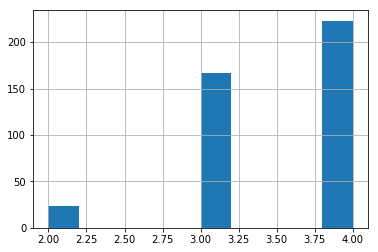

In [22]:
training_data_df[BEST_EPOCH].hist()

In [23]:
training_data_df[TOTAL_DURATION].describe()

count    414.000000
mean     313.775362
std       10.425582
min      282.000000
25%      313.250000
50%      316.000000
75%      318.000000
max      351.000000
Name: Total_Duration(s), dtype: float64

In [24]:
training_data_df.groupby([TRAINING_NUMBER]).describe()[TEST_F1_MEASURE].sort_values(by='mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
Training_Number,,,,,,,,
5,36.0,0.811372,0.008136,0.784385,0.811018,0.813266,0.815340,0.821507
1,52.0,0.808114,0.007881,0.779282,0.805207,0.810970,0.813297,0.817466
6,36.0,0.807510,0.006188,0.792169,0.804388,0.808535,0.811360,0.817160
7,36.0,0.807345,0.005875,0.788376,0.805543,0.808342,0.810995,0.816451
8,43.0,0.807171,0.008502,0.780364,0.802544,0.809291,0.812334,0.821088
4,36.0,0.806226,0.004876,0.795297,0.803047,0.805814,0.810517,0.815143
2,44.0,0.805919,0.006350,0.787665,0.803354,0.807067,0.810829,0.816709
0,52.0,0.800180,0.007260,0.778806,0.796440,0.800538,0.803728,0.820331
3,36.0,0.798951,0.010384,0.772564,0.793288,0.798859,0.806804,0.812715


In [25]:
rp.summary_cont(training_data_df[TEST_F1_MEASURE])

,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,Test_F1_Measure,414.0,0.804768,0.008674,0.000426,0.80393,0.805605


In [26]:
rp.summary_cont(training_data_df.groupby(EMBEDDING))[TEST_F1_MEASURE]

,N,Mean,SD,SE,95% Conf.,Interval
Embedding,,,,,,
No,85,0.805413,0.007926,0.000860,0.803727,0.807098
fasttext,94,0.799760,0.008828,0.000911,0.797976,0.801545
glove,47,0.805515,0.008741,0.001275,0.803016,0.808014
wang2vec,94,0.805926,0.008204,0.000846,0.804267,0.807585
word2vec,94,0.807659,0.007647,0.000789,0.806113,0.809205


In [27]:
# Calculating effect size
def anova_table(aov):
    aov['mean_sq'] = aov[:]['sum_sq']/aov[:]['df']
    
    aov['eta_sq'] = aov[:-1]['sum_sq']/sum(aov['sum_sq'])
    
    aov['omega_sq'] = (aov[:-1]['sum_sq']-(aov[:-1]['df']*aov['mean_sq'][-1]))/(sum(aov['sum_sq'])+aov['mean_sq'][-1])
    
    cols = ['sum_sq', 'mean_sq', 'df', 'F', 'PR(>F)', 'eta_sq', 'omega_sq']
    aov = aov[cols]
    return aov

def print_anova(parameter):
    # Fits the model with the interaction term
    # This will also automatically include the main effects for each factor
    model = ols('Test_F1_Measure ~ C({0})'.format(parameter), training_data_df).fit()
    # Seeing if the overall model is significant
    print(f"Overall model F({model.df_model: .0f},{model.df_resid: .0f}) = {model.fvalue: .3f}, p = {model.f_pvalue: .20f}")
    print(model.summary())
    res = sm.stats.anova_lm(model, typ= 2)
    print(res)
    print(anova_table(res))
    mc = statsmodels.stats.multicomp.MultiComparison(training_data_df[TEST_F1_MEASURE], training_data_df[parameter])
    mc_results = mc.tukeyhsd()
    print(mc_results)

In [28]:
print_anova(EMBEDDING)

Overall model F( 4, 409) =  12.277, p =  0.00000000194779292944
                            OLS Regression Results                            
Dep. Variable:        Test_F1_Measure   R-squared:                       0.107
Model:                            OLS   Adj. R-squared:                  0.098
Method:                 Least Squares   F-statistic:                     12.28
Date:                Fri, 21 Jun 2019   Prob (F-statistic):           1.95e-09
Time:                        17:00:24   Log-Likelihood:                 1402.0
No. Observations:                 414   AIC:                            -2794.
Df Residuals:                     409   BIC:                            -2774.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------

In [29]:
training_data_df[(training_data_df.Embedding == 'wang2vec') & (training_data_df.Embedding_Type == 'skip') & (training_data_df.Representation == 'ELMo+Embeddings')]

,Training_ID,Model,Representation,Embedding,Embedding_Type,Training_Number,Execution_Number,Best_Epoch,Training_Epochs,Training_Duration,Total_Duration(s),Average_Epoch_Duration(s),Training_Accuracy,Training_Accuracy_Top-3,Training_Precision,Training_Recall,Training_F1-Measure,Training_Loss,Best_Validation_Accuracy,Best_Validation_Accuracy_Top-3,Best_Validation_Precision,Best_Validation_Recall,Best_Validation_F1-Measure,Best_Validation_Loss,Test_Accuracy,Test_Accuracy_Top-3,Test_Precision,Test_Recall,Test_F1_Measure,Test_Loss
400,harem-ft2_ELMo+Embeddings_wang2vec_skip_0_4,harem-ft2,ELMo+Embeddings,wang2vec,skip,0,4,3,5,00:04:50,290.0,58.0,0.988301,0.989208,0.877690,0.868932,0.873289,24.889342,0.979128,0.981314,0.798995,0.811224,0.805063,50.660930,0.976931,0.978762,0.817865,0.782638,0.799864,56.630261
401,harem-ft2_ELMo+Embeddings_wang2vec_skip_1_4,harem-ft2,ELMo+Embeddings,wang2vec,skip,1,4,3,5,00:05:22,322.0,64.4,0.987991,0.988975,0.880556,0.868711,0.874594,25.265647,0.985859,0.986756,0.843829,0.874674,0.858974,33.524452,0.976871,0.978582,0.814217,0.791653,0.802776,54.962672
404,harem-ft2_ELMo+Embeddings_wang2vec_skip_8_3,harem-ft2,ELMo+Embeddings,wang2vec,skip,8,3,4,5,00:05:01,301.0,60.2,0.988048,0.989182,0.877881,0.866468,0.872137,25.437860,0.983880,0.985267,0.864198,0.857843,0.861009,42.801871,0.977156,0.979227,0.818369,0.794324,0.806167,56.239780
405,harem-ft2_ELMo+Embeddings_wang2vec_skip_9_3,harem-ft2,ELMo+Embeddings,wang2vec,skip,9,3,4,5,00:04:59,299.0,59.8,0.987989,0.989100,0.882321,0.871587,0.876921,25.688119,0.978771,0.980728,0.818859,0.822943,0.820896,49.722932,0.977021,0.978732,0.807114,0.787980,0.797432,55.965740
